# radial basis function neural networks(RBFNNs)

In [13]:
%matplotlib inline 
from IPython.core.display import display

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pylab as plot
params = {
    'legend.fontsize': 20,
    'axes.labelsize': 18,
}
plot.rcParams.update(params)

from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from matplotlib import cm
import numpy as np
import pandas as pd
from sympy import *
from sympy.utilities.lambdify import lambdify
import matplotlib.figure
init_printing()
#from math import *
from interval import interval, inf
from interval import imath
import sys
from pprint import pprint
import datetime
import os

In [14]:
! echo '' > find_all_solution.out
from ivmat import ivmat as ip
from fmat import fmat
from krawczyk import Krawczyk
from symbol_derivative import(
    get_f_df_ddf_from_symbol_representation,
    get_global_minima_from_f_expr,
    calc_f_expr_meshgrid,
    plot3D,
    visualize_optimization_log,
)
from nelder_mead import (
    NelderMead,
)

## $NN(x_1, x_2) = exp(-4(x_1 - 1)^2  -  6(x_2 - 0.5)^2) + exp(-7(x_1+1.5)^2 - 9(x_2+1)^2)$
where $x_1 \in [-2,2], x_2 \in [-2,2]$

### グラフの可視化

In [15]:
x_1, x_2, x_3 = var("x_1 x_2 x_3")
f_expr = exp(-4*(x_1-1)**2 - 6*(x_2-0.5)**2) + exp(-7*(x_1+1.5)**2 - 9*(x_2+1)**2)
f_expr = - f_expr

args = (x_1, x_2)
f_func = lambdify(args, f_expr, modules=imath)
f = fmat([[f_func]])

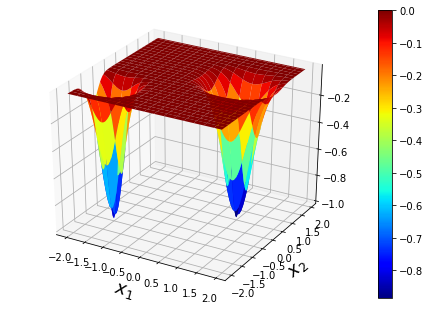

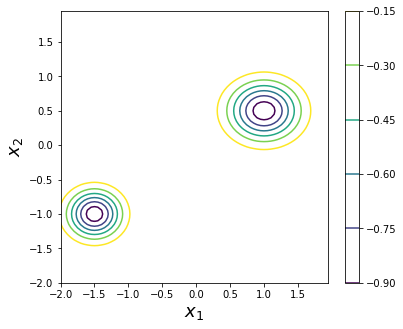

In [16]:

x = np.arange(-2, 2, 0.05) 
y = np.arange(-2, 2, 0.05) 

X, Y = np.meshgrid(x, y)
args_list =  np.array([X.flatten(), Y.flatten()]).T[:, :, np.newaxis]
Z = np.array([ip.mid(f(_args))[0][0] for _args in args_list]).reshape(X.shape)

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(X,Y,Z, rstride=3, cstride=5, cmap=cm.jet, linewidth=1) 
fig.colorbar(surf)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.show()

fig = plt.figure(figsize=(6, 5))
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
im =plt.contour(X, Y, Z, shading='gouraud')
fig.colorbar(im)


## local minimaを求める

In [5]:
np_func = lambdify([args], f_expr, modules=np)
# seed_num = 324
# np.random.seed(seed_num)
low = -2
high = 2
points = np.random.uniform(low=low, high=high, size=(3,2))
nelder = NelderMead(np_func, points)

local_minima, points_history = nelder.run()
x = np.arange(-2, 2, 0.05) 
y = np.arange(-2, 2, 0.05) 
X, Y = np.meshgrid(x, y)
args_list =  np.array([X.flatten(), Y.flatten()]).T[:, :, np.newaxis].tolist()
Z = np.array([-nelder.func(_args) for _args in args_list]).reshape(X.shape)
print local_minima

#nelder.save_figs(X, Y, Z, points_history)

-0.999999995923


### Krawczyk method

In [6]:
f, df, ddf = get_f_df_ddf_from_symbol_representation(f_expr, args)

#### global minma

In [7]:
x_1 = interval[-2, 2]
x_2 = interval[-2, 2]
X = ip([[x_1],[x_2]])

kra = Krawczyk(df, ddf, X)
cnt_max = 2000
max_width = 1e-4

local_minima = np.inf
local_minima = -0.9999998511

%time ans_boxes, S_num_list, T_num_list, U_num_list, animation_box, max_width_time_series_list = kra.find_global_minimum(\
    f, tmp_min_sup=local_minima, trace=False, cnt_max=cnt_max, max_width=max_width)

# ans_boxes, S_num_list, T_num_list, U_num_list, animation_box = kra.find_global_minimum(
#     f, tmp_min_sup=f_val[0][0][0].sup ,trace=False, cnt_max=cnt_max, max_width=max_width)

# ans_boxes, S_num_list, T_num_list, U_num_list, animation_box = kra.find_all_solution(
#     trace=False, cnt_max=cnt_max, max_width=max_width)

Loop end. cnt:36, len(S):0, len(T):2, len(U):0

36
---------- 最終的なS[:10] -----------
[]
---------- 最終的なU[:10] -----------
[]
---------- 最終的なT[:50] -----------
[[[interval([0.9999999999999998, 1.0000000000000002])],
  [interval([0.49999999999999994, 0.5000000000000002])]],
 [[interval([-1.5000000000000009, -1.4999999999999998])],
  [interval([-1.0000000000000124, -0.9999999999999968])]]]
最小値の上限値: -1.0, 該当区間X: [[interval([0.9999999999999998, 1.0000000000000002])], [interval([0.49999999999999994, 0.5000000000000002])]]
CPU times: user 488 ms, sys: 6.09 ms, total: 494 ms
Wall time: 501 ms


## 探索の可視化

In [8]:
# skip_num = max(len(animation_box) / 20, 2)
# title_prefix = 'initial tmp_min_sup: {}, '.format(local_minima)
# visualize_optimization_log(kra, f, animation_box, skip=skip_num, title_prefix=title_prefix)

Loop end. cnt:36, len(S):0, len(T):2, len(U):0

36
---------- 最終的なS[:10] -----------
[]
---------- 最終的なU[:10] -----------
[]
---------- 最終的なT[:50] -----------
[[[interval([0.9999999999999998, 1.0000000000000002])],
  [interval([0.49999999999999994, 0.5000000000000002])]],
 [[interval([-1.5000000000000009, -1.4999999999999998])],
  [interval([-1.0000000000000124, -0.9999999999999968])]]]
最小値の上限値: -1.0, 該当区間X: [[interval([0.9999999999999998, 1.0000000000000002])], [interval([0.49999999999999994, 0.5000000000000002])]]
Loop end. cnt:62, len(S):0, len(T):2, len(U):0

62
---------- 最終的なS[:10] -----------
[]
---------- 最終的なU[:10] -----------
[]
---------- 最終的なT[:50] -----------
[[[interval([0.9999999999999998, 1.0000000000000002])],
  [interval([0.49999999999999994, 0.5000000000000002])]],
 [[interval([-1.5000000000000009, -1.4999999999999998])],
  [interval([-1.0000000000000124, -0.9999999999999968])]]]
最小値の上限値: -1.0, 該当区間X: [[interval([0.9999999999999998, 1.0000000000000002])], [interval([

[<matplotlib.text.Text at 0x111fe0350>, <matplotlib.text.Text at 0x111fa34d0>]

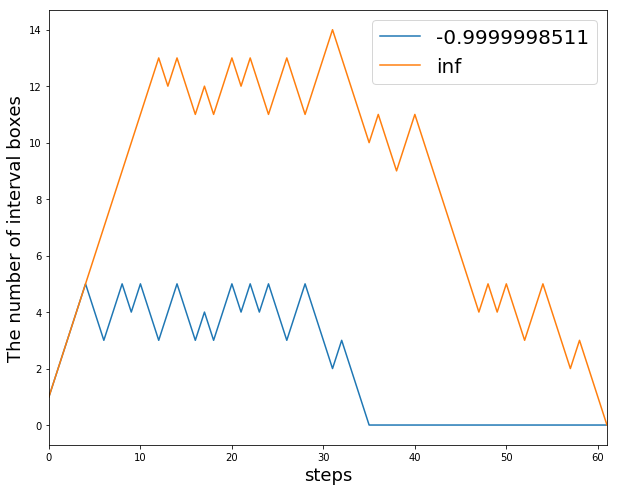

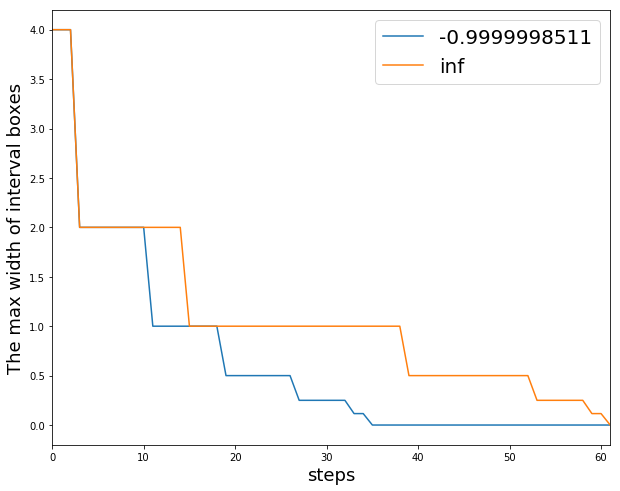

In [18]:
def fill_zero_to_right_of_list(array):
    max_len = len(max(array, key=len))
    return [li + [0] * (max_len - len(li)) for li in array]

local_minima_list = [-0.9999998511, np.inf]
_S_num_lists = [] # [S_num_list_1, ...]
_max_width_time_series_lists = []
for local_minima in local_minima_list:
    ans_boxes, S_num_list, T_num_list, U_num_list, animation_box, max_width_time_series_list = kra.find_global_minimum(\
        f, tmp_min_sup=local_minima, trace=False, cnt_max=3000, max_width=1e-14)
    _S_num_lists.append(S_num_list)
    _max_width_time_series_lists.append(max_width_time_series_list)

_result_list = fill_zero_to_right_of_list(_S_num_lists)
result_list = np.array(_result_list).T

tmp_list = fill_zero_to_right_of_list(_max_width_time_series_lists)
max_width_time_series_lists = np.array(tmp_list).T


import pandas as pd
result_df = pd.DataFrame(np.array(result_list))
result_df.columns = list(map(str, local_minima_list))
ax = result_df.plot(title='', figsize=(10, 8), legend=True)
ax.set(xlabel="steps", ylabel="The number of interval boxes")


max_width_df = pd.DataFrame(max_width_time_series_lists)
max_width_df.columns = list(map(str, local_minima_list))
ax = max_width_df.plot(title='', figsize=(10, 8), legend=True)
ax.set(xlabel="steps", ylabel="The max width of interval boxes")